## Predictive Modeling: Using Regression models to predict price of used cars.
This project aims to show the process of creating Machine Learning models based on Simple, Multiple and Polynomial Regressions.
In this project, R2 is used to evaluate the performance of the models. Pearson Coeficient's P-Value of <= 0.05 rejects the null hypotesis.

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
from IPython.display import display, clear_output

In [2]:
#ETL e Data Cleaning
def PrepData(pathfile,carmodelname,target): ##remove nulls in price
    df = pd.read_csv(pathfile)
    df['car_name'] = df['manufacturer_name'] + '-' + df['model_name']
    df = df[df['car_name'].isin([carmodelname])].reset_index(drop=True).drop(['feature_1','feature_2','feature_3','feature_4','feature_5','feature_6','feature_7','feature_8','feature_9','duration_listed','engine_has_gas','engine_type','has_warranty','is_exchangeable','location_region','number_of_photos','body_type','up_counter','feature_0','manufacturer_name','model_name','car_name'],axis=1)
    df = df[df['price_usd'] > 0]
    for column in df.columns:
        if (df[column] == df[column][0]).all():
            df.drop(columns=column,inplace=True)
    TargetVar = df[target]
    df.drop(columns=[target],axis=1,inplace=True)
    df.insert(0,target,TargetVar)
    dfobject = df.select_dtypes(include='object')
    df = df.select_dtypes(exclude='object')
    dummiesdf = pd.concat([dfobject, pd.get_dummies(dfobject[list(dfobject)])],axis=1).drop(dfobject[list(dfobject)],axis=1)
    mergeddf = pd.merge(df,dummiesdf,left_index=True,right_index=True)
    targetcol = mergeddf[target]                                                            
    return dfobject, targetcol, mergeddf, target

#Pearson coefficient calculation
def CoefPearson(df,targetname):
    lcoef = []
    lp = []
    for col in list(df.columns):
        coef, p = stats.pearsonr(df[col],df[targetname])
        lcoef.append(coef)
        lp.append(round(p,3))
    return pd.DataFrame(lcoef).merge(pd.DataFrame(lp),on=df.columns).rename(columns={'key_0':'IndependentVar','0_x':'PearsonCoef','0_y':'P-Value'}).drop([0]).reset_index(drop=True)

#Listing n independent variables with p <= 0.05
def NLargAbsCoef(df,targetname,n):
    df = CoefPearson(df,targetname)
    df = df[df['P-Value'] <= 0.05].reset_index(drop=True).loc[df['PearsonCoef'].abs().nlargest(n,keep='first').index]
    return list(df['IndependentVar'])

#Listing all indepedent variables with p <= 0.05
def AllCoef(df,targetname):
    df = CoefPearson(df,targetname)
    df = df[df['P-Value'] <= 0.05].reset_index(drop=True)
    return list(df['IndependentVar'])

In [3]:
#Analysis Function
def PlotandAnalysis(BPdfobj,targetcol,df,targetname,polydegrees):
    def BoxplotObjects(BPdfobj,targetcol): ## Show counts on plot ##better show car colors
        fig, axs = plt.subplots(ncols=len(list(BPdfobj)), figsize=(16,4),sharey=True)
        t = 0
        for column in list(BPdfobj):
            sns.boxplot(x=BPdfobj[column],y=targetcol,data=BPdfobj, ax=axs[t])
            t += 1
        plt.show()
        plt.close()

    #Simple Linear Regression Model and Plot
    def SLRModelandPlot(df,targetcol,targetname):
        x = df[[NLargAbsCoef(df,targetname,1)[0]]].values
        m = LinearRegression().fit(x,targetcol)
        fig, axs = plt.subplots(ncols=2, figsize=(16,4))
        ax0 = sns.regplot(x=x,y=targetcol,data=df,ax=axs[0])
        ax1 = sns.residplot(x=x,y=targetcol,data=df,ax=axs[1])
        ax0.set_ylim(0,)
        ax0.set_xlim(x.min(),)
        plt.show()
        plt.close()
        print('Simple Linear Regression Model Equation:\n',m.intercept_,'+',float(m.coef_),'*',targetcol.name)
        return x,m

    #Multiple Linear Regression Model and Plot
    def MLRModelandPlot(df,targetcol,targetname): #adapt to get max num of var and better show model equation
        x = df[AllCoef(df,targetname)].values
        m = LinearRegression().fit(x,targetcol)
        plt.figure(figsize=(16,4))
        ax1 = sns.kdeplot(targetcol, color="r", label="Actual Value")
        sns.kdeplot(m.predict(x), color="b", label="Predicted Values", ax=ax1)
        plt.title('Actual (red) vs Predicted (blue) Price')
        plt.xlabel('Price')
        plt.ylabel('Proportion of Cars')
        plt.xlim(0,)
        plt.show()
        plt.close()
        print("MLR Intercept:",m.intercept_)
        print("MLR Coefs:",list(m.coef_))
        return x,m

    #Polynomial Regression Model and Plot
    def PlotPR(df,targetcol,polydegrees,targetname): #adapt to get best degree
        x = df[NLargAbsCoef(df,targetname,1)[0]].values
        m = np.poly1d(np.polyfit(x, targetcol, polydegrees))
        x_new = np.linspace(x.min(),x.max())
        y_new = m(x_new)
        plt.plot(x, targetcol, '.', x_new, y_new, '-')
        ax = plt.gca()
        ax.set_facecolor((0.898, 0.898, 0.898))
        fig = plt.gcf()
        plt.show()
        plt.close()
        print('Polynomial Regression Model Equation:\n',m)
        return x,m

    #R2 calculation
    def R2(realY,predictY):
        return r2_score(realY,predictY)

    #Comparison of best model by R2 criteria
    def ModelComparison(x1,m1,x2,m2,x3,m3,targetcol):
        print('\n-------------------------------------------------------------------\n')
        md = ['Simple Linear Regression','Multiple Linear Regression','Polynomial Regression']
        preds = [m1.predict(x1),m2.predict(x2),m3(x3)]
        bestr2 = 0
        for pred, q in zip(list(preds), md):
            r2 = R2(targetcol,pred)
            print(q,'R2:',r2)
            if r2 > bestr2:
                bestr2 = r2
                bestq = q
        print('\nBest model by R2 is',bestq,'with R2 of',bestr2)

    BoxplotObjects(BPdfobj,targetcol)
    slrx, slrm = SLRModelandPlot(df,targetcol,targetname)
    mlrx, mlrm = MLRModelandPlot(df,targetcol,targetname)
    prx, prm = PlotPR(df,targetcol,polydegrees,targetname)
    ModelComparison(slrx,slrm,mlrx,mlrm,prx,prm,targetcol)

In [4]:
def car_selector():
    df = pd.read_csv('../PredictiveModelingRegression/cars.csv')
    dropdown_manufacturer = widgets.Dropdown(options = sorted(list(set(df['manufacturer_name']))))
    output = widgets.Output()

    def output_by_manufacturer(manufacturer):
        with output:
            IPython.display.clear_output(wait=True)
            output_data = df[df['manufacturer_name'] == manufacturer]
            display(output_data)     

    def dropdown_state_eventhandler(change):
            display(input_widgets)
            output_by_manufacturer(change.new) 

    dropdown_manufacturer.observe(dropdown_state_eventhandler, names='value')
    input_widgets = widgets.HBox([dropdown_manufacturer])
    display(input_widgets,output)

In [5]:
car_selector()

Output()

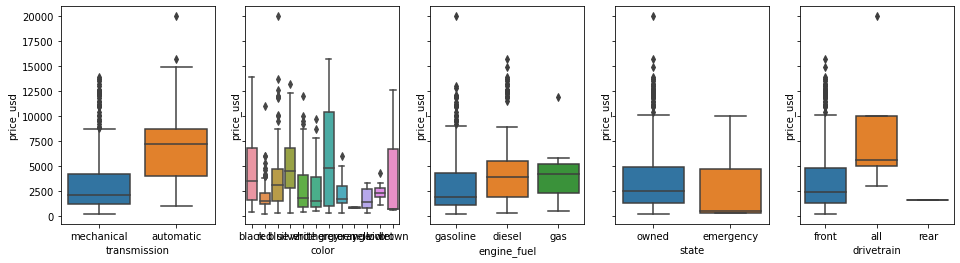

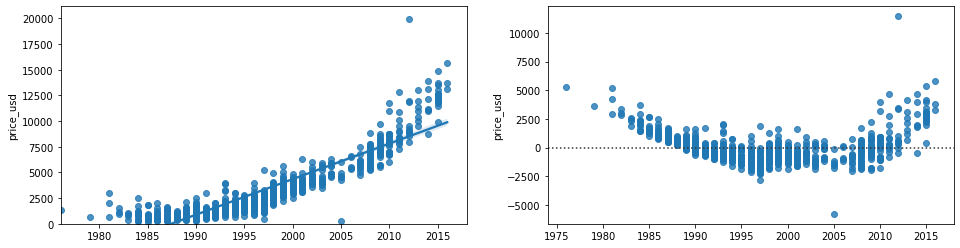

Simple Linear Regression Model Equation:
 -687740.0671526314 + 346.0436035430563 * price_usd


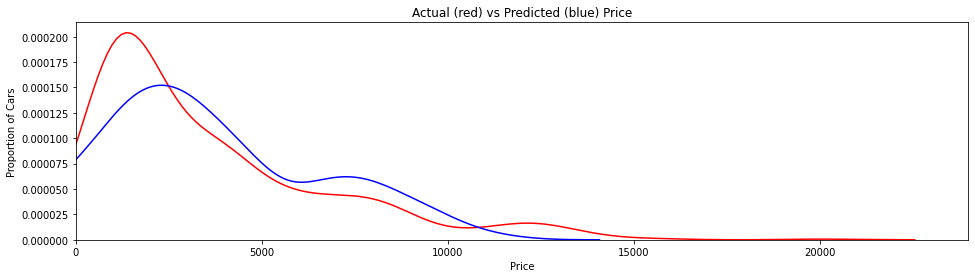

MLR Intercept: -630565.3149226797
MLR Coefs: [-0.0003170814503313186, 318.94396060375624, -1178.005760944823, 426.3759665854557, -426.37596658545783, 228.33381167292768, -97.81654735937887, 898.1080795880218, -166.67513906193707, -199.7386030585114, -134.49567191730236, 715.2565320325081, 102.36729614906815, 2290.7657913387434, -1026.1180113779137]


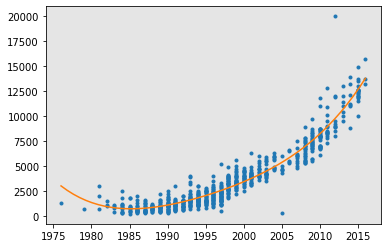

Polynomial Regression Model Equation:
          4       3             2
0.01755 x - 140 x + 4.191e+05 x - 5.576e+08 x + 2.781e+11

-------------------------------------------------------------------

Simple Linear Regression R2: 0.8134058215471239
Multiple Linear Regression R2: 0.8378731807182898
Polynomial Regression R2: 0.9223584199254606

Best model by R2 is Polynomial Regression with R2 of 0.9223584199254606


In [6]:
pf = '../PredictiveModelingRegression/cars.csv' #pathfile of the dataset
carmodel = 'Volkswagen-Golf' # To be replaced by car_selector()
PlotandAnalysis(*PrepData(pf,carmodel,'price_usd'),4)